In [2]:
#import ddsp
#print(ddsp.__file__)

In [3]:
#!pip uninstall ddsp

In [1]:
def print_dict(d):
    for k, v in d.items():
        print(f"\t'{k}': {v}")

def print_dict2(d):
    l = 0
    for detail in d:
        print()
        print(f'item #{l}:')
        l = l + 1

        i = 0
        for k, v in detail.items():
            if i == 0:
                print(f"\t'{k}': {v}")
            else:
                print(f"\t\t'{k}': {v}")

In [8]:
import os
import platform
import sys

if platform.system() == 'Windows':
    midi_ddsp_module_path = os.path.abspath(os.path.join('../../'))
    ddsp_module_path = os.path.abspath(os.path.join('../../../ddsp-playground-2/'))
else:
    midi_ddsp_module_path = os.path.abspath(os.path.join('../../'))
    ddsp_module_path = os.path.abspath(os.path.join('../../../ddsp/ddsp-playground-2/'))

def apply_module_path(module_path):
    print(f"module_path={module_path}")
    if module_path not in sys.path:
      sys.path.append(module_path)
      print(f"appending {module_path} to sys.path")
    else:
      print(f"do not appending {module_path} to sys.path")

apply_module_path(midi_ddsp_module_path)
apply_module_path(ddsp_module_path)

import sys
if platform.system() != 'Windows':
    sparsenet_module_path_abs = '/ssd003/home/burakovr/projects/vova/envs/main/lib/python3.8/site-packages/'
    apply_module_path(sparsenet_module_path_abs)

import midi_ddsp

module_path=E:\Code\Projects\TimbreTransfer\midi-ddsp-main
do not appending E:\Code\Projects\TimbreTransfer\midi-ddsp-main to sys.path
module_path=E:\Code\Projects\TimbreTransfer\ddsp-playground-2
do not appending E:\Code\Projects\TimbreTransfer\ddsp-playground-2 to sys.path


In [9]:
#  Copyright 2022 The MIDI-DDSP Authors.
#  #
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#  #
#      http://www.apache.org/licenses/LICENSE-2.0
#  #
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

"""Training code for Synthesis Generator."""

import tensorflow as tf
import time
import os
import sys
import logging
import argparse
import IPython

from keras.utils.layer_utils import print_summary
from livelossplot import PlotLosses

from midi_ddsp.data_handling.get_dataset import get_dataset
from midi_ddsp.utils.training_utils import print_hparams, set_seed, \
    save_results, str2bool
from midi_ddsp.utils.summary_utils import write_tensorboard_audio
#                          from midi_ddsp.hparams_synthesis_generator import hparams as hp
from midi_ddsp.hparams_synthesis_generator import hparams_debug as hp
from midi_ddsp.modules.recon_loss import ReconLossHelper
from midi_ddsp.modules.gan_loss import GANLossHelper
from midi_ddsp.modules.get_synthesis_generator import get_synthesis_generator, \
    get_fake_data_synthesis_generator
from midi_ddsp.modules.discriminator import Discriminator
from ddsp.colab.notebook_utils import play, specplot


In [10]:
print(tf.__version__)

2.9.3


In [11]:

parser = argparse.ArgumentParser(description='Train Synthesis Generator.')
plotlosses = PlotLosses()

#set_seed(hp.seed)
losses_history = [] # per step
eval_losses_history = [] # per epoch


In [12]:
#export_to_tflite(model, f'{log_dir}/heylol.tflite')

In [13]:
#print(append_postfix_to_filename('logs/logs_synthesis_generator/full_train_and_export/heylol.tflite', '_what'))

In [14]:
input_signature_offline_model = (
    tf.TensorSpec(shape=[64000], dtype=tf.float32),
    tf.TensorSpec(shape=[1000], dtype=tf.float32),
    tf.TensorSpec(shape=[1000], dtype=tf.float32),
    tf.TensorSpec(shape=[1000], dtype=tf.float32),
    tf.TensorSpec(shape=[1000], dtype=tf.float32),
    tf.TensorSpec(shape=[1000], dtype=tf.float32),
    tf.TensorSpec(shape=[1000], dtype=tf.float32),
    tf.TensorSpec(shape=[512], dtype=tf.float32),
)

call_fn = tf.function(model_vst.call, input_signature=input_signature_offline_model)
concrete_func = call_fn.get_concrete_function(*input_signature_offline_model)

# Convert the model_vst to TFLite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

#model.run_without_synths = True
#model.run_synth_coder_only = True

#converter = tf.lite.TFLiteConverter.from_keras_model(model_vst)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS ]

print('starting conversion..')
tflite_model = converter.convert()
print('conversion finished')

import pathlib

tflite_model_file = pathlib.Path(f'{log_dir}/clean_model_vst_frame_size_64.tflite')
tflite_model_file.write_bytes(tflite_model)
print(f'tflite model saved')

NameError: name 'model_vst' is not defined

In [15]:
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)

    input_details = interpreter.get_input_details()
    #print(f"input_details={[detail['name'] for detail in input_details]}")
    print(f"\n\n Inputs (len={len(input_details)}):")
    #print(input_details)
    print_dict2(input_details)
    
    output_details = interpreter.get_output_details()
    print(f"\n\n Outputs (len={len(output_details)}):")
    print_dict2(output_details)
    
    return interpreter, input_details, output_details

In [16]:
def run_tflite_inference(interpreter, inputs):
    
    def set_inputs_for_tflite(interpreter, interpreter_input):
    #interpreter_input = eval_sample_batch

        for key, value in interpreter_input.items():
            print(f"")
            #print(f"#{i}: trying to set {key}. It's value is {value}")

            good_detail = None
            for detail in input_details:
                #print(detail['name'][16:-2])
                if detail['name'][16:-2] == key or detail['name'] == key:
                    good_detail = detail
                    break

            if good_detail is None:
                print(f"Unable to find {key}. Skipping")
            else:

                print(f"Our raw input value: {tf.shape(value)}")
                print(f"trying to set {good_detail['name']} with tensor of shape {tf.shape(value)}")

                interpreter.set_tensor(good_detail['index'], tf.cast(value, good_detail['dtype']))

    
    def get_outputs_from_tflite(interpreter):
        #f0_hz  = interpreter.get_tensor(input_details[1]['index'])
        #amps   = interpreter.get_tensor(output_details[11]['index'])
        #noises = interpreter.get_tensor(output_details[14]['index'])
        #hd     = interpreter.get_tensor(output_details[13]['index'])

        f0_hz  = interpreter.get_tensor(input_details[1]['index'])
        amps   = interpreter.get_tensor(output_details[0]['index'])
        noises = interpreter.get_tensor(output_details[3]['index'])
        hd     = interpreter.get_tensor(output_details[2]['index'])
        
        #amps    = tf.reshape(amps,      [1, 1, 1])
        #noises  = tf.reshape(noises,    [1, 1, 60])
        #hd      = tf.reshape(hd,        [1, 1, 65])

        synth_params = {
            'f0_hz': f0_hz,
            'amplitudes': amps,
            'harmonic_distribution': hd,
            'noise_magnitudes': noises
        }

        return synth_params
    
    interpreter.allocate_tensors()
    
    set_inputs_for_tflite(interpreter=interpreter, interpreter_input=inputs)
    
    interpreter.invoke()
    
    tflite_synth_params = get_outputs_from_tflite(interpreter)
    
    return tflite_synth_params

In [54]:
tflite_input_for_model_vst = {
    'audio':         tf.reshape(eval_sample_batch['audio'][0], [64000]),
    'f0_hz':         tf.reshape(eval_sample_batch['f0_hz'][0], [1000]),
    'instrument_id': tf.reshape(eval_sample_batch['instrument_id'][0], [1]),
    'loudness_db':   tf.reshape(eval_sample_batch['loudness_db'][0], [1000]),
    'midi':          tf.reshape(eval_sample_batch['midi'][0], [1000]),
    'onsets':        tf.reshape(eval_sample_batch['onsets'][0], [1000]),
    'offsets':       tf.reshape(eval_sample_batch['offsets'][0], [1000]),
}

model_vst_outputs = model_vst(**tflite_input_for_model_vst, state=tf.random.uniform([512]))

model_vst_outputs['f0_hz']                 = tf.reshape(tflite_input_for_model_vst['f0_hz'],          [1, 1000, 1])
model_vst_outputs['amplitudes']            = tf.reshape(model_vst_outputs['amplitudes'],              [1, 1000, 1])
model_vst_outputs['harmonic_distribution'] = tf.reshape(model_vst_outputs['harmonic_distribution'],   [1, 1000, 60])
model_vst_outputs['noise_magnitudes']      = tf.reshape(model_vst_outputs['noise_magnitudes'],        [1, 1000, 65])

my_control_params = my_processor_group.get_controls(model_vst_outputs, verbose=False)
my_synth_audio = my_processor_group.get_signal(my_control_params)

play(my_synth_audio)

MIDIExpressionAE_VST_IO_Wrapper.__call__()
{'audio': <tf.Tensor: shape=(1, 64000), dtype=float32, numpy=
array([[-0.0015042 , -0.00600021, -0.01005646, ...,  0.0032625 ,
         0.00275293, -0.00052424]], dtype=float32)>, 'loudness_db': <tf.Tensor: shape=(1, 1000, 1), dtype=float32, numpy=
array([[[ -73.55207 ],
        [ -73.76381 ],
        [ -73.90305 ],
        [ -73.80584 ],
        [ -73.6492  ],
        [ -73.47191 ],
        [ -73.21132 ],
        [ -73.00183 ],
        [ -72.88918 ],
        [ -72.75301 ],
        [ -72.66828 ],
        [ -72.578674],
        [ -72.665596],
        [ -72.755325],
        [ -72.872246],
        [ -73.05596 ],
        [ -73.23429 ],
        [ -73.388466],
        [ -73.489784],
        [ -73.53572 ],
        [ -73.6606  ],
        [ -73.80354 ],
        [ -73.964355],
        [ -73.972534],
        [ -73.71389 ],
        [ -73.40541 ],
        [ -73.140236],
        [ -72.85046 ],
        [ -72.490074],
        [ -72.09717 ],
        [ -71.7594

In [70]:
from midi_ddsp.utils.inference_utils import get_process_group

my_processor_group = get_process_group(model.n_frames, model.frame_size, model.sample_rate, use_angular_cumsum=False)

interpreter, input_details, output_details = load_tflite_model(model_path=f'{log_dir}/clean_model_synth_only.tflite')

tflite_input_single_batch = {k : tf.expand_dims(v[0], axis=0) for k, v in eval_sample_batch.items() }

tflite_input_for_model_vst = {
    'audio':         tf.reshape(eval_sample_batch['audio'][0], [64000]),
    'f0_hz':         tf.reshape(eval_sample_batch['f0_hz'][0], [1000]),
    'instrument_id': tf.reshape(eval_sample_batch['instrument_id'][0], [1]),
    'loudness_db':   tf.reshape(eval_sample_batch['loudness_db'][0], [1000]),
    'midi':          tf.reshape(eval_sample_batch['midi'][0], [1000]),
    'onsets':        tf.reshape(eval_sample_batch['onsets'][0], [1000]),
    'offsets':       tf.reshape(eval_sample_batch['offsets'][0], [1000]),
}

tflite_synth_params = run_tflite_inference(interpreter=interpreter, 
                                           inputs=tflite_input_single_batch)

my_control_params = my_processor_group.get_controls(tflite_synth_params, verbose=False)
my_synth_audio = my_processor_group.get_signal(my_control_params)

play(my_synth_audio)



 Inputs (len=7):

item #0:
	'name': audio
	'index': 0
	'shape': [    1 64000]
	'shape_signature': [    1 64000]
	'dtype': <class 'numpy.float32'>
	'quantization': (0.0, 0)
	'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}
	'sparsity_parameters': {}

item #1:
	'name': f0_hz
	'index': 1
	'shape': [   1 1000    1]
	'shape_signature': [   1 1000    1]
	'dtype': <class 'numpy.float32'>
	'quantization': (0.0, 0)
	'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}
	'sparsity_parameters': {}

item #2:
	'name': instrument_id
	'index': 2
	'shape': [1]
	'shape_signature': [1]
	'dtype': <class 'numpy.int64'>
	'quantization': (0.0, 0)
	'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}
	'sparsity_parameters': {}

item #3:
	'name': loudness_db
	'index': 3
	'shape': 

dict_keys(['f0_hz', 'amplitudes', 'harmonic_distribution', 'noise_magnitudes'])


In [17]:
def append_postfix_to_filename(file_path, postfix):
    # Split the path into folder, file base, and file extension
    folder, file_name = os.path.split(file_path)
    file_base, file_ext = os.path.splitext(file_name)
    
    # Add the postfix to the file base
    new_file_base = file_base + postfix

    # Combine the new file base with the file extension
    new_file_name = new_file_base + file_ext

    # Combine the folder with the new file name
    new_file_path = os.path.join(folder, new_file_name)
    
    return new_file_path

In [18]:
def export_to_tflite(ae_model, path):
    #ae_copy = get_synthesis_generator(hp)
    #ae_copy._build(get_fake_data_synthesis_generator(hp))
    #ae_copy(train_sample_batch)
    #ae_copy.set_weights(ae_model.get_weights())
    
    orig_run_without_synths = ae_model.run_without_synths
    orig_run_inside_vst = ae_model.run_inside_vst
    orig_run_synth_coder_only = ae_model.run_synth_coder_only

    ae_model.run_without_synths = True
    ae_model.run_inside_vst = True
    ae_model.run_synth_coder_only = False

    #ae_copy.reverb_module = None
    #ae_copy.processor_group = None
    
    
    model_vst = MIDIExpressionAE_VST_IO_Wrapper(ae_model=model, vst_buffer_size=1024, vst_frame_size=1024)
    
    # build it
    def get_fake_vst_inputs(buffer_size_in_samples, n_frames_in_buffer):
        # 16 frames == 1 buffer

        audio           = tf.random.uniform([buffer_size_in_samples])
        loudness_db     = tf.random.uniform([n_frames_in_buffer])
        f0_hz           = tf.random.uniform([n_frames_in_buffer])
        midi            = tf.random.uniform([n_frames_in_buffer])
        onsets          = tf.random.uniform([n_frames_in_buffer])
        offsets         = tf.random.uniform([n_frames_in_buffer])
        instrument_id   = tf.random.uniform([1])

        return audio, loudness_db, f0_hz, midi, onsets, offsets, instrument_id

    vst_inputs = get_fake_vst_inputs(buffer_size_in_samples=1024,
                                    n_frames_in_buffer=1)

    model_vst(*vst_inputs, state=tf.random.uniform([512]))
    print('model_vst is built')
    
    # CONVERT
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.DEBUG)
    #
    # converter = tf.lite.TFLiteConverter.from_keras_model(model_vst)
    #
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS ]
    #
    # #converter.representative_dataset = training_data
    #
    # tflite_model = converter.convert()

    # Define the input signature
    
    # frame size is 64 here
    input_signature_offline = (
        tf.TensorSpec(shape=[64000], dtype=tf.float32),
        tf.TensorSpec(shape=[1000], dtype=tf.float32),
        tf.TensorSpec(shape=[1000], dtype=tf.float32),
        tf.TensorSpec(shape=[1000], dtype=tf.float32),
        tf.TensorSpec(shape=[1000], dtype=tf.float32),
        tf.TensorSpec(shape=[1000], dtype=tf.float32),
        tf.TensorSpec(shape=[1000], dtype=tf.float32),
        tf.TensorSpec(shape=[512], dtype=tf.float32),
    )
    
    input_signature_realtime = (
        tf.TensorSpec(shape=[1024], dtype=tf.float32),
        tf.TensorSpec(shape=[1], dtype=tf.float32),
        tf.TensorSpec(shape=[1], dtype=tf.float32),
        tf.TensorSpec(shape=[1], dtype=tf.float32),
        tf.TensorSpec(shape=[1], dtype=tf.float32),
        tf.TensorSpec(shape=[1], dtype=tf.float32),
        tf.TensorSpec(shape=[1], dtype=tf.float32),
        tf.TensorSpec(shape=[512], dtype=tf.float32),
    )

    # Wrap the model_vst's call method with the call_wrapper function
    
    def convert_and_save(target_model, save_path):
        call_fn = tf.function(model_vst.call, input_signature=input_signature)
        concrete_func = call_fn.get_concrete_function(*input_signature)

        # Convert the model_vst to TFLite
        converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS ]

        print('starting conversion..')
        tflite_model = converter.convert()
        print('conversion finished')

        import pathlib

        tflite_model_file = pathlib.Path(save_path)
        tflite_model_file.write_bytes(tflite_model)
        print(f'tflite model saved to {save_path}')
    
    model_vst.ae.run_synth_coder_only=False
    convert_and_save(model_vst, save_path=append_postfix_to_filename(path, '_midi'))
    
    model_vst.ae.run_synth_coder_only=True
    convert_and_save(model_vst, save_path=append_postfix_to_filename(path, '_synth'))
    
    ae_model.run_without_synths = orig_run_without_synths
    ae_model.run_inside_vst = orig_run_inside_vst
    ae_model.run_synth_coder_only = orig_run_synth_coder_only
    

In [19]:
def train(training_data, training_data_length, training_epochs, start_epoch=1):
    
    """Training loop including evaluation."""
    start_time = time.time()
    loss_helper.reset_metrics()

    steps_in_epoch = int(training_data_length) # do not need to divide by hp.batch_size because each item is a batch itself
    logging.info(f"Starting training: epochs={training_epochs}, steps_in_epoch={steps_in_epoch}, start_epoch={start_epoch}")
    step = 0

    for epoch in range(start_epoch, training_epochs + start_epoch + 1):
        for i, data in enumerate(training_data):
            step = ((epoch-1) * steps_in_epoch + i) + 1
            print(f"training on epoch={epoch}, step={step}")

            # Run the model and get the loss.
            with tf.GradientTape() as tape, tf.GradientTape() as disc_tape:
                outputs = model(data, training=True, run_synth_coder_only=hp.run_synth_coder_only)

                loss_dict_recon = loss_helper.compute_loss(data, outputs,
                                                           synth_coder_only=hp.run_synth_coder_only,
                                                           add_synth_loss=hp.add_synth_loss)

                if not hp.run_synth_coder_only and hp.use_gan:
                    cond, real_outputs, fake_outputs = gan_loss_helper.get_disc_input(outputs)
                    D_fake = net_D([cond, fake_outputs])
                    D_real = net_D([cond, real_outputs])
                    loss_dict_disc = gan_loss_helper.compute_disc_loss(D_fake, D_real)
                    loss, loss_dict_gen = gan_loss_helper.compute_gen_loss(D_fake, D_real, loss_dict_recon['total_loss'])
                else:
                    loss = loss_dict_recon['total_loss']

            # Clip and apply gradients.
            grads = tape.gradient(loss, model.trainable_variables)
            grads, _ = tf.clip_by_global_norm(grads, hp.clip_grad)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            loss_helper.update_metrics(loss_dict_recon)
            loss_helper.write_summary(loss_dict_recon, writer, 'Train', step)
            
            losses_history.append(loss_dict_recon)
            plotlosses.update({'loss': loss_dict_recon['total_loss']})
            
            # Train discriminator and update GAN loss.
            if not hp.run_synth_coder_only and hp.use_gan:
                gradients_of_discriminator = disc_tape.gradient(loss_dict_disc['disc_loss'], net_D.trainable_variables)
                optimizer_disc.apply_gradients(zip(gradients_of_discriminator, net_D.trainable_variables))
                gan_loss_helper.update_metrics(loss_dict_disc)
                gan_loss_helper.write_summary(loss_dict_disc, writer, 'Train', step)
                gan_loss_helper.update_metrics(loss_dict_gen)
                gan_loss_helper.write_summary(loss_dict_gen, writer, 'Train', step)
            
            plotlosses.send()
            
        # Print logging summary.
        if epoch % hp.log_interval == 0:
            elapsed = time.time() - start_time
            current_lr = optimizer._decayed_lr('float32').numpy()
            msg = f'| {epoch:6d} epoch | lr {current_lr:02.2e} ' \
                  f'| ms/batch {(elapsed * 1000 / hp.log_interval):5.2f} '
            msg = msg + loss_helper.get_loss_log()
            loss_helper.reset_metrics()
            if not hp.run_synth_coder_only:
                msg = msg + gan_loss_helper.get_loss_log()
                gan_loss_helper.reset_metrics()
            logging.info(msg)

            # Print a message on the same line
            IPython.display.clear_output()
            print(msg)

            start_time = time.time()

        # Evaluate.
        if epoch % hp.eval_interval == 0:
            eval_start_time = time.time()
            
            eval_loss_dict = evaluate(evaluation_data, epoch=epoch, step=step)

            plotlosses.update({'val_acc': eval_loss_dict['total_loss']})
            eval_losses_history.append(eval_loss_dict)
            
            # Synthesize training data.
            outputs = model(train_sample_batch, training=True, run_synth_coder_only=hp.run_synth_coder_only)
            
            save_results(outputs['synth_audio'], train_sample_batch['audio'], log_dir, f'train_{epoch}_synth', hp.sample_rate)
            if 'midi_audio' in outputs.keys():
                save_results(outputs['midi_audio'], train_sample_batch['audio'], log_dir, f'train_{epoch}_midi', hp.sample_rate)
            if hp.write_tfrecord_audio:
                write_tensorboard_audio(writer, train_sample_batch, outputs, epoch, tag='Train')

            # Synthesize evaluation data.
            outputs = model(eval_sample_batch, training=False, run_synth_coder_only=hp.run_synth_coder_only)
            save_results(outputs['synth_audio'], eval_sample_batch['audio'], log_dir, f'eval_{epoch}_synth', hp.sample_rate)
            if 'midi_audio' in outputs.keys():
                save_results(outputs['midi_audio'], eval_sample_batch['audio'], log_dir, f'eval_{epoch}_midi', hp.sample_rate)
            if hp.write_tfrecord_audio:
                write_tensorboard_audio(writer, eval_sample_batch, outputs, epoch, tag='Eval')
            
            eval_time_elapsed = time.time() - eval_start_time
            logging.info(f"Evaluation took {eval_time_elapsed*1000}ms")
        
        # DDSP Inference training finished.
        # Start training Synthesis Generator and dump dataset for expression generator.
        if (epoch - start_epoch + 1) >= hp.synth_coder_training_epochs:
            hp.run_synth_coder_only = False
            if not hp.add_synth_loss:
                model.freeze_synth_coder()

        # Save weights for the whole model.
        if epoch % hp.checkpoint_save_interval == 0:
            model.save_weights(f'{log_dir}/e{epoch}_s{step}')
            try:
                export_to_tflite(ae_model=model, path=f'{log_dir}/e{epoch}_s{step}.tflite')
            except Exception as e:
                logging.error(traceback.format_exc())
                print("An exception occurred while exporting to tflite")
            
            
        plotlosses.send()


def evaluate(evaluation_data, epoch, step):
    """Evaluating the test set."""
    eval_loss_helper = ReconLossHelper(hp, eval_recon_loss=True)
    start_time = time.time()
    for data in evaluation_data:
        outputs = model(data, training=False, run_synth_coder_only=hp.run_synth_coder_only)

        loss_dict = eval_loss_helper.compute_loss(data, outputs,synth_coder_only=hp.run_synth_coder_only)
        eval_loss_helper.update_metrics(loss_dict)

    eval_loss_helper.write_mean_summary(writer, 'Eval', step)
    msg = f'eval: | epoch {epoch:6d} | eval time: {(time.time() - start_time):3.3f}'
    msg = msg + eval_loss_helper.get_loss_log()
    logging.info(msg)
    
    return eval_loss_helper.get_loss_dict()


In [20]:
parser.add_argument('--batch_size', type=int, default=hp.batch_size,
                    help='Batch size to use for training.')
parser.add_argument('--nhid', type=int, default=hp.nhid,
                    help='Number of hidden dimensions in '
                         'Synthesis Generator.')
parser.add_argument('--training_epochs', type=int, default=hp.training_epochs,
                    help='Number of training epochs to take.')
parser.add_argument('--eval_interval', type=int, default=hp.eval_interval,
                    help='The number of training epochs to take '
                         'evaluation on whole evaluation set.')
parser.add_argument('--checkpoint_save_interval', type=int,
                    default=hp.checkpoint_save_interval,
                    help='The number of training epochs to take before save '
                         'the model weights once.')
parser.add_argument('--data_dir', type=str, default=hp.data_dir,
                    help='The directory to tfrecord data files.')
parser.add_argument('--restore_path', type=str, default=hp.restore_path,
                    help='The path to the model weights file for restore '
                         'training.')
parser.add_argument('--midi_audio_loss', type=str2bool, nargs='?', const=True,
                    default=hp.midi_audio_loss,
                    help='Whether to use '
                         'multi-scale spectral loss on audio predicted')
parser.add_argument('--synth_params_loss', type=str2bool, nargs='?',
                    const=True, default=hp.synth_params_loss,
                    help='Whether to use L1 loss on synthesis parameters '
                         'predicted.')
parser.add_argument('--train_synth_coder_first', type=str2bool, nargs='?',
                    const=True, default=hp.train_synth_coder_first,
                    help='Whether to train DDSP Inference first or joint '
                         'training DDSP Inference and Synthesis Generator.')
parser.add_argument('--add_synth_loss', type=str2bool, nargs='?', const=True,
                    default=hp.add_synth_loss,
                    help='Whether to add DDSP Inference loss to the '
                         'total loss for back-prop.')
parser.add_argument('--multi_instrument', type=str2bool, nargs='?',
                    const=True, default=hp.multi_instrument,
                    help='Whether to train multi-instrument model or '
                         'single-instrument model')
parser.add_argument('--position_code', type=str, default=hp.position_code,
                    help='Whether to use positional encoding in '
                         'Synthesis Generator, and what type of '
                         'positional encoding.')
parser.add_argument('--midi_decoder_type', type=str,
                    default=hp.midi_decoder_type,
                    help='The type of Synthesis Generator.')
parser.add_argument('--midi_decoder_decoder_net', type=str,
                    default=hp.midi_decoder_decoder_net,
                    help='The network type for Synthesis Generator.')
parser.add_argument('--reverb', type=str2bool, nargs='?', const=True,
                    default=hp.reverb, help='Whether to use reverb.')
parser.add_argument('--reverb_length', type=int, default=hp.reverb_length,
                    help='The length for the reverb impulse response.')
parser.add_argument('--instrument', type=str, default=hp.instrument,
                    help='The instrument to train on for single instrument '
                         'setting.')
parser.add_argument('--synth_coder_training_epochs', type=int,
                    default=hp.synth_coder_training_epochs,
                    help='The number of epochs for training DDSP Inference.')
parser.add_argument('--use_gan', type=str2bool, nargs='?', const=True,
                    default=hp.use_gan, help='Whether to use GAN training '
                                             'for Synthesis Generator.')
parser.add_argument('--lambda_recon', type=float, default=hp.lambda_recon,
                    help='The weight for the reconstruction loss.')
parser.add_argument('--lambda_G', type=float, default=hp.lambda_G,
                    help='The weight for the discriminator loss '
                         'for generator.')
parser.add_argument('--sg_z', type=str2bool, nargs='?', const=True,
                    default=hp.sg_z, help='Whether to stop the gradient for'
                                          'conditioning sequence (z) in '
                                          'discriminator.')
parser.add_argument('--lr_disc', type=float, default=hp.lr_disc,
                    help='The learning rate for discriminator.')
parser.add_argument('--without_note_expression', type=str2bool, nargs='?',
                    const=True, default=hp.without_note_expression,
                    help='Whether to train Synthesis Generator using no note '
                         'expression controls. Used in paper rebuttal.')
parser.add_argument('--mode', type=str, default=hp.mode,
                    help='The mode to run, train or eval.')
parser.add_argument('--name', type=str, default='logs_synthesis_generator',
                    help='The name of the log folder.')


_StoreAction(option_strings=['--name'], dest='name', nargs=None, const=None, default='logs_synthesis_generator', type=<class 'str'>, choices=None, help='The name of the log folder.', metavar=None)

In [21]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [23]:
#hp.data_dir = '../data/'
hp.data_dir = '../../data/'

hp.training_epochs = 32 # 5k steps
hp.log_interval = 1
hp.checkpoint_save_interval = 1
hp.eval_interval = 1
hp.synth_coder_training_epochs = 24
hp.batch_size=1
#hp.batch_size=1
hp.reverb_length = 16000
experiment_name = "12343256244"

In [12]:
hp.data_dir = '../data/'
#hp.data_dir = '../../data/'

hp.vst_inference_mode = False
hp.train_synth_coder_first = True
hp.training_epochs = 64 # 5k steps
hp.log_interval = 1
hp.checkpoint_save_interval = 1
hp.eval_interval = 1
hp.synth_coder_training_epochs = 32
#hp.batch_size=10
hp.batch_size=10
hp.reverb_length = 16000
experiment_name = "full_train_and_export"

In [13]:
hp.restore_path=f'logs/logs_synthesis_generator/full_train_and_export/e53_s10281'

In [14]:
#hp.frame_size = 1024

In [15]:
#hp.vst_inference_mode = False

In [24]:
# Load dataset.
training_data, length_training_data, evaluation_data, length_evaluation_data = get_dataset(hp, training_data_repeats=1)

# Filter the data so that we don't use values we don't need

# do not keep 'f0_confidence', 'note_active_frame_indices', 'note_active_velocities', 'note_offsets', 'note_onsets', 'power_db',  'recording_id',
keys_to_keep = ['audio',
                'f0_hz',
                'instrument_id',
                'loudness_db',
                'midi',
                'onsets',
                'offsets']
# TODO: What to do with 'mel'? Is it used?

def filter_keys_in_dataset(example):
    return {key: example[key] for key in keys_to_keep}

training_data = training_data.map(filter_keys_in_dataset)
evaluation_data = evaluation_data.map(filter_keys_in_dataset)

# Debug purposes
training_data = training_data#.take(10)
evaluation_data = evaluation_data#.take(10)

eval_sample_batch = next(iter(evaluation_data))
train_sample_batch = next(iter(training_data))
logging.info('Data loaded! Data size: %s', str(length_training_data))

In [25]:
print(eval_sample_batch.keys())
print(train_sample_batch)

dict_keys(['audio', 'f0_hz', 'instrument_id', 'loudness_db', 'midi', 'onsets', 'offsets'])
{'audio': <tf.Tensor: shape=(1, 64000), dtype=float32, numpy=
array([[-0.00066383, -0.00115081, -0.00374312, ..., -0.00298944,
        -0.00391929, -0.00653601]], dtype=float32)>, 'f0_hz': <tf.Tensor: shape=(1, 1000, 1), dtype=float32, numpy=
array([[[584.7245 ],
        [585.61176],
        [586.5682 ],
        [587.52466],
        [588.0134 ],
        [588.41425],
        [588.9528 ],
        [589.7565 ],
        [590.5601 ],
        [591.0616 ],
        [591.5064 ],
        [591.8654 ],
        [592.05945],
        [592.2534 ],
        [592.5391 ],
        [592.8419 ],
        [593.0561 ],
        [593.1001 ],
        [593.1441 ],
        [593.1328 ],
        [593.1112 ],
        [593.08875],
        [593.06476],
        [593.0408 ],
        [592.8889 ],
        [592.7133 ],
        [592.43634],
        [591.9655 ],
        [591.4946 ],
        [590.8558 ],
        [590.1857 ],
        [589.57

In [26]:
from midi_ddsp.modules.model.model_vst import MIDIExpressionAE_VST_IO_Wrapper

# Create Synthesis Generator
model = get_synthesis_generator(hp)

In [27]:
print(f"model.run_synth_coder_only={model.run_synth_coder_only},\n"
      f"model.run_without_synths={model.run_without_synths},\n"
      f"model.run_inside_vst={model.run_inside_vst}")

model.run_synth_coder_only=False,
model.run_without_synths=False,
model.run_inside_vst=False


In [28]:
#model.run_synth_coder_only = True
#model.midi_decoder = None
#model.synth_coder.encoder.extract_f0 = True

In [29]:
#model.run_without_synths = True
model.run_without_synths = False

In [30]:
model.run_without_synths = True
model.run_inside_vst = True
model.run_synth_coder_only = False

model.reverb_module = None
model.processor_group = None

In [31]:
model._build(get_fake_data_synthesis_generator(hp))

MIDIExpressionAE.__call__()
SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()
tf.shape(s_vibrato)=[128 513]
tf.shape(pitch_deviation_masked)=[ 128 1024]
tf.shape(s_vibrato)=[128 500]
tf.shape(each_note_len)=[  1   1 128]
tf.shape(tf.reshape(each_note_len, [-1, 1]))=[128   1]
FcStack: reshaped x to (1000, 10).
FcStack: reshaped x back to (1, 1000, 512).
MidiToSynthAutoregDecoder.__call__()
MidiExpreToF0AutoregDecoder.call(), training=True
MidiExpreToF0AutoregDecoder.preprocess()
MidiExpreToF0AutoregDecoder.teacher_force()
end of MidiExpreToF0AutoregDecoder.teacher_force()
MidiExpreToF0AutoregDecoder.postprocess()
MidiExpreToF0AutoregDecoder.call(), training=True
MidiExpreToF0AutoregDecoder.preprocess()
MidiExpreToF0AutoregDecoder.teacher_force()
end of MidiExpreToF0AutoregDecoder.teacher_force()
MidiExpreToF0AutoregDecoder.postprocess()
MidiExpreToSynthDecoder.__call__()


In [32]:
tf.get_logger().setLevel('DEBUG')

In [33]:
print(tf.keras.Model.summary(model, expand_nested=True))

Model: "midi_expression_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 synth_coder (SynthCoder)    multiple                  7119550   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| mel_f0ld_encoder (MelF0LDEn  multiple               7054912   |
| coder)                                                        |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| cnn8 (Cnn8)             multiple                  4689984   ||
|||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|||
||| conv_block (ConvBlock)  multiple                37952     |||
||||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||||
|||| conv2d (Conv2D)     multiple                  576       ||||
||||                                                         ||||
|||| conv2d_1 (Conv2D)   multiple                  36864     ||||
||||                                            

In [ ]:
oo = model(train_sample_batch)
play(oo['synth_audio'])
play(oo['midi_audio'])

In [34]:
# Create optimizer, loss helper and discriminator.
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=hp.lr, decay_steps=1000, decay_rate=0.99)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=scheduler)

loss_helper = ReconLossHelper(hp)
gan_loss_helper = GANLossHelper(lambda_recon=hp.lambda_recon, lambda_G=hp.lambda_G, sg_z=hp.sg_z)
optimizer_disc = tf.keras.optimizers.Adam(learning_rate=hp.lr_disc)

net_D = Discriminator(nhid=hp.discriminator_dim)
# 64=instrument_emb_dim
z_dim = hp.discriminator_dim + int(hp.multi_instrument) * 64
# synth_params_dim = dim(nharmonic + nnoise + amplitude + f0)
synth_params_dim = hp.nhramonic + hp.nnoise + 2
_ = net_D((tf.random.normal([4, 1000, z_dim]), tf.random.normal([4, 1000, synth_params_dim])))


In [35]:
# Load model, create log directory and log file.
log_dir = f"logs/{parser.get_default('name')}/{experiment_name}"
print(log_dir)

logs/logs_synthesis_generator/12343256244


In [36]:
if hp.restore_path:
    print(f'restoring from {hp.restore_path}')
    model.load_weights(hp.restore_path)
    log_dir = os.path.dirname(hp.restore_path)

writer = tf.summary.create_file_writer(log_dir)
log_path = os.path.join(log_dir, 'train.log')
logging.basicConfig(level=logging.INFO,
                  format='%(asctime)s - %(levelname)s: %(message)s',
                  handlers=[
                    logging.FileHandler(log_path),
                    logging.StreamHandler(sys.stdout)]
                  )


In [37]:
#model.save_weights(f'{log_dir}/{1000}')
#model.load_weights(f'logs/logs_synthesis_generator/experiment_5/e24_s4655.index')

In [38]:
#model.run_synth_coder_only = True

In [39]:
from midi_ddsp.utils.inference_utils import get_process_group

my_processor_group = get_process_group(model.n_frames, model.frame_size, model.sample_rate, use_angular_cumsum=False)

In [40]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13394939074932946599
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2915486926
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15620580170732917597
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [41]:
# Print model summary and hyperparameters.
model.summary(print_fn=logging.info)
logging.info(str(print_hparams(hp)))

In [42]:
model_vst = MIDIExpressionAE_VST_IO_Wrapper(ae_model=model, vst_buffer_size=1024, vst_frame_size=1024)

#model_vst = MIDIExpressionAE_VST_IO_Wrapper(ae_model=model, vst_buffer_size=64000, vst_frame_size=64)

In [44]:
def get_vst_inputs(buffer_idx, buffer_size_in_samples, n_frames_in_buffer, source_batch):
    # 16 frames == 1 buffer
    
    n_dataset_frame_size = source_batch['audio'].shape[1] // source_batch['f0_hz'].shape[1]
    n_dataset_frames_in_buffer = buffer_size_in_samples // n_dataset_frame_size
    n_dataset_frames_in_one_user_frame = n_dataset_frames_in_buffer // n_frames_in_buffer
    ds_frame_pos = buffer_idx * n_dataset_frames_in_one_user_frame # on which frame the given buffer starts

    print()
    print(f'n_dataset_frame_size={n_dataset_frame_size}')
    print(f'n_dataset_frames_in_buffer={n_dataset_frames_in_buffer}')
    print(f'n_dataset_frames_in_one_user_frame={n_dataset_frames_in_one_user_frame}')
    print(f'ds_frame_pos={ds_frame_pos}')
    print()

    audio           = source_batch['audio'][0][buffer_idx*buffer_size_in_samples:(buffer_idx+1)*buffer_size_in_samples]
    loudness_db =   tf.reshape(source_batch['loudness_db'][0][ds_frame_pos:ds_frame_pos+n_frames_in_buffer], [n_frames_in_buffer])
    f0_hz           = tf.reshape(source_batch['f0_hz'][0][ds_frame_pos:ds_frame_pos+n_frames_in_buffer], [n_frames_in_buffer])
    midi            = source_batch['midi'][0][ds_frame_pos:ds_frame_pos+n_frames_in_buffer]
    onsets          = source_batch['onsets'][0][ds_frame_pos:ds_frame_pos+n_frames_in_buffer]
    offsets         = source_batch['offsets'][0][ds_frame_pos:ds_frame_pos+n_frames_in_buffer]
    instrument_id   = tf.reshape(source_batch['instrument_id'][0], [1])

    return audio, loudness_db, f0_hz, midi, onsets, offsets, instrument_id



#print(f"vst_eval_sample_batch: audio={audio.shape}, loudness_db={loudness_db.shape}, f0_hz={f0_hz.shape}, midi={midi.shape}, onsets={onsets.shape}, offsets={offsets.shape}, instrument_id={instrument_id.shape}")

vst_inputs = get_vst_inputs(buffer_idx=0,
                          buffer_size_in_samples=model_vst.vst_buffer_size,
                          n_frames_in_buffer=model_vst.vst_buffer_size // model_vst.vst_frame_size,
                          source_batch=eval_sample_batch)

print([x.shape for x in vst_inputs])
model_vst_outputs = model_vst(*vst_inputs, state=tf.random.uniform([512]))


n_dataset_frame_size=64
n_dataset_frames_in_buffer=1000
n_dataset_frames_in_one_user_frame=1
ds_frame_pos=0

[TensorShape([64000]), TensorShape([1000]), TensorShape([1000]), TensorShape([1000]), TensorShape([1000]), TensorShape([1000]), TensorShape([1])]
MIDIExpressionAE_VST_IO_Wrapper.__call__()
{'audio': <tf.Tensor: shape=(1, 64000), dtype=float32, numpy=
array([[-0.0015042 , -0.00600021, -0.01005646, ...,  0.0032625 ,
         0.00275293, -0.00052424]], dtype=float32)>, 'loudness_db': <tf.Tensor: shape=(1, 1000, 1), dtype=float32, numpy=
array([[[ -73.55207 ],
        [ -73.76381 ],
        [ -73.90305 ],
        [ -73.80584 ],
        [ -73.6492  ],
        [ -73.47191 ],
        [ -73.21132 ],
        [ -73.00183 ],
        [ -72.88918 ],
        [ -72.75301 ],
        [ -72.66828 ],
        [ -72.578674],
        [ -72.665596],
        [ -72.755325],
        [ -72.872246],
        [ -73.05596 ],
        [ -73.23429 ],
        [ -73.388466],
        [ -73.489784],
        [ -73.5

In [46]:
print(model_vst_outputs.keys())

dict_keys(['amplitudes', 'harmonic_distribution', 'noise_magnitudes', 'state'])


In [61]:
print(model.n_frames, model.frame_size, model.sample_rate)

1000 64 16000


In [27]:
#model.run_without_synths = True
#model.run_inside_vst = True
#model.run_synth_coder_only = False

model_res = model(eval_sample_batch)

print(f"model_res.keys()={model_res.keys()}")

my_control_params = my_processor_group.get_controls(model_res['midi_synth_params'], verbose=False)
my_synth_audio = my_processor_group.get_signal(my_control_params)

play(my_synth_audio)


accum_sound = None
num_buffers = 62
for buffer_idx in range(num_buffers):

    vst_inputs = get_vst_inputs(buffer_idx=buffer_idx,
                                buffer_size_in_samples=1024,
                                n_frames_in_buffer=1,
                                source_batch=eval_sample_batch)
    without_synths_res = model_vst(*vst_inputs, state=tf.random.uniform([512]))

    without_synths_res['amplitudes']            = tf.reshape(without_synths_res['amplitudes'],              [1, 1, 1])
    without_synths_res['harmonic_distribution'] = tf.reshape(without_synths_res['harmonic_distribution'],   [1, 1, 60])
    without_synths_res['noise_magnitudes']      = tf.reshape(without_synths_res['noise_magnitudes'],        [1, 1, 65])

    #print(f"without_synths_res.keys()={without_synths_res.keys()}")
    #print(f"without_synths_res.values.shape()={[v.shape for v in without_synths_res.values()]}")

    without_synths_res['f0_hz'] = vst_inputs[2]
    #without_synths_res['amplitudes']=tf.reshape(without_synths_res['amplitudes'], [1, 16, 1])
    #without_synths_res['harmonic_distribution']=tf.reshape(without_synths_res['harmonic_distribution'], [1, 60, 1])
    #without_synths_res['noise_magnitudes']=tf.reshape(without_synths_res['noise_magnitudes'], [1, 65, 1])

    my_processor_group_vst = get_process_group(n_frames=1, frame_size=1024, sample_rate=model.sample_rate, use_angular_cumsum=False)

    my_control_params = my_processor_group_vst.get_controls(without_synths_res, verbose=False)
    my_synth_audio = my_processor_group_vst.get_signal(my_control_params)

    #print(f"my_synth_audio.shape={my_synth_audio.shape}")

    play(my_synth_audio)
    if accum_sound is None:
        accum_sound = my_synth_audio
    else:
        accum_sound = tf.concat([accum_sound, my_synth_audio], axis=1)
    #print(f"my_control_params={my_control_params.keys()}")

    print(f"frame_idx={buffer_idx}")

print("finally..")
play(accum_sound)

IndentationError: unexpected indent (1529598639.py, line 6)

In [42]:
ae = model_vst.ae

ae.run_without_synths = True
ae.run_inside_vst = True
ae.run_synth_coder_only = False

ae.reverb_module = None
ae.processor_group = None

#model_vst(eval_sample_batch)

In [36]:
model_vst.save('test_save_model_vst_full___vst_format')

In [ ]:
oo = model(train_sample_batch)
play(oo['midi_audio'])
print(oo.keys())
pgoo = my_processor_group(oo)
#print(pgoo.keys())

play(pgoo)

In [43]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.DEBUG)
#
# converter = tf.lite.TFLiteConverter.from_keras_model(model_vst)
#
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS ]
#
# #converter.representative_dataset = training_data
#
# tflite_model = converter.convert()

# Define the input signature
input_signature = (
    tf.TensorSpec(shape=[1024], dtype=tf.float32),
    tf.TensorSpec(shape=[1], dtype=tf.float32),
    tf.TensorSpec(shape=[1], dtype=tf.float32),
    tf.TensorSpec(shape=[1], dtype=tf.float32),
    tf.TensorSpec(shape=[1], dtype=tf.float32),
    tf.TensorSpec(shape=[1], dtype=tf.float32),
    tf.TensorSpec(shape=[1], dtype=tf.float32),
    tf.TensorSpec(shape=[512], dtype=tf.float32),
)

# Wrap the model_vst's call method with the call_wrapper function
#wrapped_call = tf.function(call_wrapper, input_signature=input_signature)
call_fn = tf.function(model_vst.call, input_signature=input_signature)
concrete_func = call_fn.get_concrete_function(*input_signature)

# Convert the model_vst to TFLite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS ]

tflite_model = converter.convert()

MIDIExpressionAE_VST_IO_Wrapper.__call__()
{'audio': <tf.Tensor 'Reshape:0' shape=(1, 1024) dtype=float32>, 'loudness_db': <tf.Tensor 'Reshape_1:0' shape=(1, 1, 1) dtype=float32>, 'f0_hz': <tf.Tensor 'Reshape_2:0' shape=(1, 1, 1) dtype=float32>, 'midi': <tf.Tensor 'Reshape_3:0' shape=(1, 1) dtype=float32>, 'onsets': <tf.Tensor 'Reshape_4:0' shape=(1, 1) dtype=float32>, 'offsets': <tf.Tensor 'Reshape_5:0' shape=(1, 1) dtype=float32>, 'instrument_id': <tf.Tensor 'instrument_id:0' shape=(1,) dtype=float32>}
MIDIExpressionAE.__call__()
SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()
tf.shape(s_vibrato)=Tensor("midi_expression_ae/expression_midi_decoder_1/Shape_2:0", shape=(2,), dtype=int32)
tf.shape(pitch_deviation_masked)=Tensor("midi_expression_ae/expression_midi_decoder_1/Shape_3:0", shape=(2,), dtype=int32)
tf.shape(s_vibrato)=Tensor("midi_expression_ae/expression_midi_decoder_1/Shape_4:0", shape=(2,), dtype=int32)
tf.shape(each_note_len)=Tensor("midi_expre

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


In [44]:
log_dir_tflite = f"{log_dir}/tflite.tflite"
#log_dir_tflite = f'tflite_tests/vn_full_untrained_optimized_for_latency__with_padding_for_rfft_4_with_reshapeback__and_1024_frame_size_5.tflite'
#log_dir_tflite = f'DDSP_VST_Trained_model/tflite/My_Instrument.tflite'
#log_dir_tflite = f'tflite_tests/vn_full_untrained.tflite'

In [45]:
import pathlib

tflite_model_file = pathlib.Path(log_dir_tflite)
tflite_model_file.write_bytes(tflite_model)

11927216

In [ ]:
interpreter = tf.lite.Interpreter(model_path=log_dir_tflite)

input_details = interpreter.get_input_details()
#print(f"input_details={[detail['name'] for detail in input_details]}")
print(f"\n\n Inputs (len={len(input_details)}):")
#print(input_details)
print_dict2(input_details)

In [ ]:
output_details = interpreter.get_output_details()
print(f"\n\n Outputs (len={len(output_details)}):")
print_dict2(output_details)

In [48]:
print(input_details[0]['name'][16:])

In [49]:
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [75]:
i = 0

interpreter_input = eval_sample_batch

for key, value in interpreter_input.items():
    print(f"")
    #print(f"#{i}: trying to set {key}. It's value is {value}")
    i = i + 1
    good_detail = None
    for detail in input_details:
        #print(detail['name'][16:-2])
        if detail['name'][16:-2] == key or detail['name'] == key:
            good_detail = detail
            break

    if good_detail is None:
        print(f"Unable to find {key}. Skipping")
    else:

        print(f"Our raw input value: {tf.shape(value)}")
        # if batch_size exists at all. We know that all the inputs that have 2 or more dims have batch size.
        if len(tf.shape(value)) >= 2:
            print(f"fixing batch size for {good_detail['name']}")
            example_from_batch_0 = value[0] # len(shape) = len(shape(value)) - 1
            with_fixed_batch_size = tf.expand_dims(example_from_batch_0, 0)
        elif len(tf.shape(value) <= 1):
            example_from_batch_0 = value[0]
            with_fixed_batch_size = tf.expand_dims(example_from_batch_0, 0)

        print(f"trying to set {good_detail['name']} with tensor of shape {tf.shape(with_fixed_batch_size)}")
        interpreter.set_tensor(good_detail['index'], tf.cast(with_fixed_batch_size, good_detail['dtype']))


Our raw input value: [    9 64000]
fixing batch size for audio
trying to set audio with tensor of shape [    1 64000]


ValueError: Cannot set tensor: Dimension mismatch. Got 2 but expected 1 for input 0.

In [ ]:
interpreter.invoke()

In [ ]:
amps = interpreter.get_tensor(output_details[0]['index'])
noises = interpreter.get_tensor(output_details[1]['index'])
hd = interpreter.get_tensor(output_details[3]['index'])

synth_params = {
    'f0_hz': interpreter_input['f0_hz'],
    'amplitudes': amps,
    'harmonic_distribution': hd,
    'noise_magnitudes': noises
}

my_control_params = my_processor_group.get_controls(synth_params, verbose=False)
my_synth_audio = my_processor_group.get_signal(my_control_params)

play(my_synth_audio)

In [58]:
from mltk.core import view_model

view_model(log_dir_tflite, tflite=True)

Serving 'E:/Code/Projects/TimbreTransfer/midi-ddsp-main/midi_ddsp/colab/tflite_tests/vn_full_untrained_optimized_for_latency__with_padding_for_rfft_4_with_reshapeback__and_1024_frame_size.tflite' at http://localhost:8080
Stopping http://localhost:8080


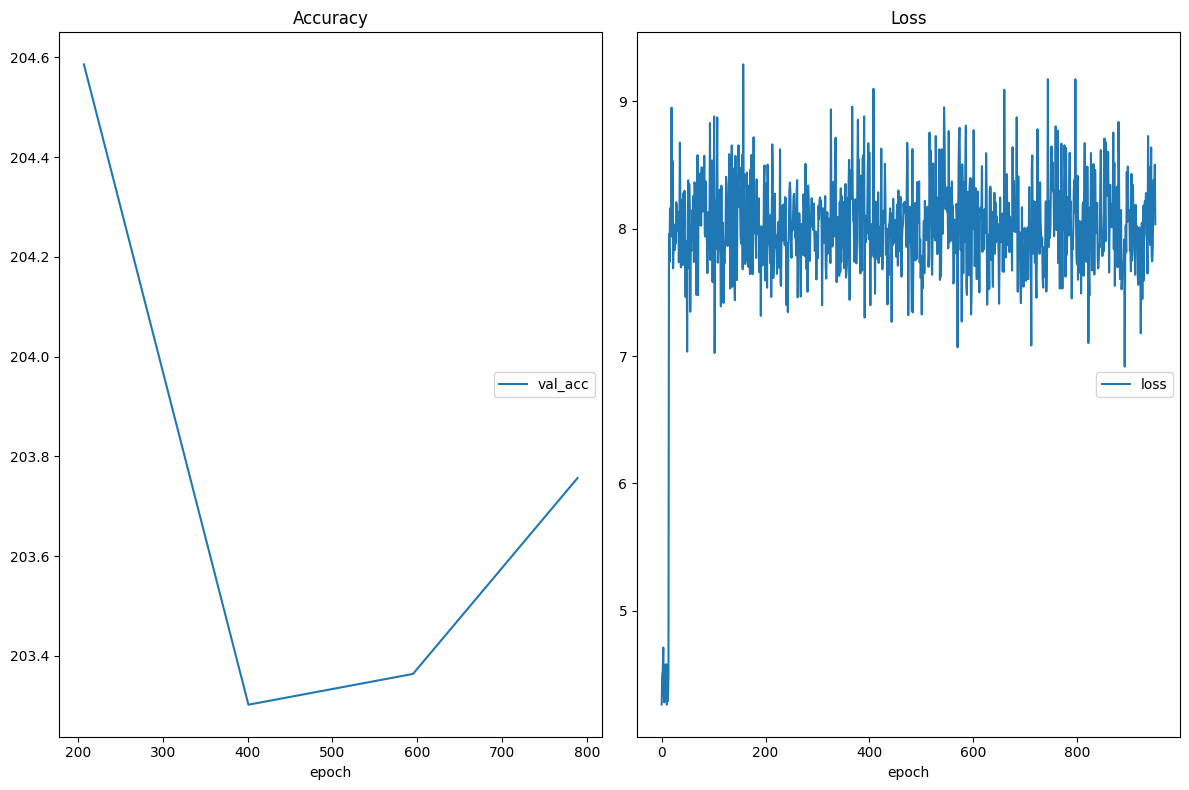

Accuracy
	val_acc          	 (min:  203.302, max:  204.586, cur:  203.757)
Loss
	loss             	 (min:    4.263, max:    9.291, cur:    8.035)
training on epoch=57, step=11027
MIDIExpressionAE.__call__()
SynthCoder.__call__()
MelF0LDEncoder.__call__()
FCHarmonicDecoder.__call__()


KeyboardInterrupt: 

In [39]:
# Start training loop

if hp.restore_path:
    bname = os.path.basename(hp.restore_path)
    parts = bname.split(sep='_')
    start_epoch = int(parts[0][1:])
    
    if hp.train_synth_coder_first is True and start_epoch > hp.synth_coder_training_epochs:
        hp.train_synth_coder_first = False
else:
    start_epoch = 1

print(start_epoch)
print(hp.train_synth_coder_first)

if hp.mode == 'train':
    if hp.train_synth_coder_first:
      hp.run_synth_coder_only = True
      model.train_synth_coder_only()
    else:
      hp.run_synth_coder_only = False

    train(training_data=training_data, training_data_length=length_training_data, training_epochs=hp.training_epochs, start_epoch=start_epoch)

elif hp.mode == 'eval':
    hp.run_synth_coder_only = False
    evaluate(evaluation_data, epoch=start_epoch, step=int(start_epoch/length_training_data))

In [ ]:
import matplotlib.pyplot as plt

total_losses = [item['total_loss'] for item in losses_history]

plt.figure(figsize=(40,10))
plt.locator_params(nbins=30)

ax = plt.gca()
ax.set_ylim([0, 20])

plt.plot(total_losses, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Steps')
plt.ylabel('Total Loss')
plt.legend()
plt.show()
ax

#plt.savefig(f'{log_dir}/loss.png')

In [ ]:
import matplotlib.pyplot as plt

total_losses = [item['total_loss'] for item in eval_losses_history]
#total_losses = [1, 2, 5]

plt.figure(figsize=(40,10))
plt.locator_params(nbins=30)

ax = plt.gca()
ax.set_ylim([0, 20])

plt.plot(total_losses, 'g', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.show()

plt.savefig(f'{log_dir}/val_loss.png')

In [ ]:
import pickle

train_history_path=f'{log_dir}/losses_history'
eval_train_history_path=f'{log_dir}/eval_losses_history'

#with open(train_history_path, "wb") as fp:
#    pickle.dump(losses_history, fp)

#with open(eval_train_history_path, "wb") as fp:
#    pickle.dump(eval_losses_history, fp)

In [ ]:
input_audios = next(iter(training_data))

outputs = model(input_audios)

hey


Original audio: 


Reconstructed audio: 


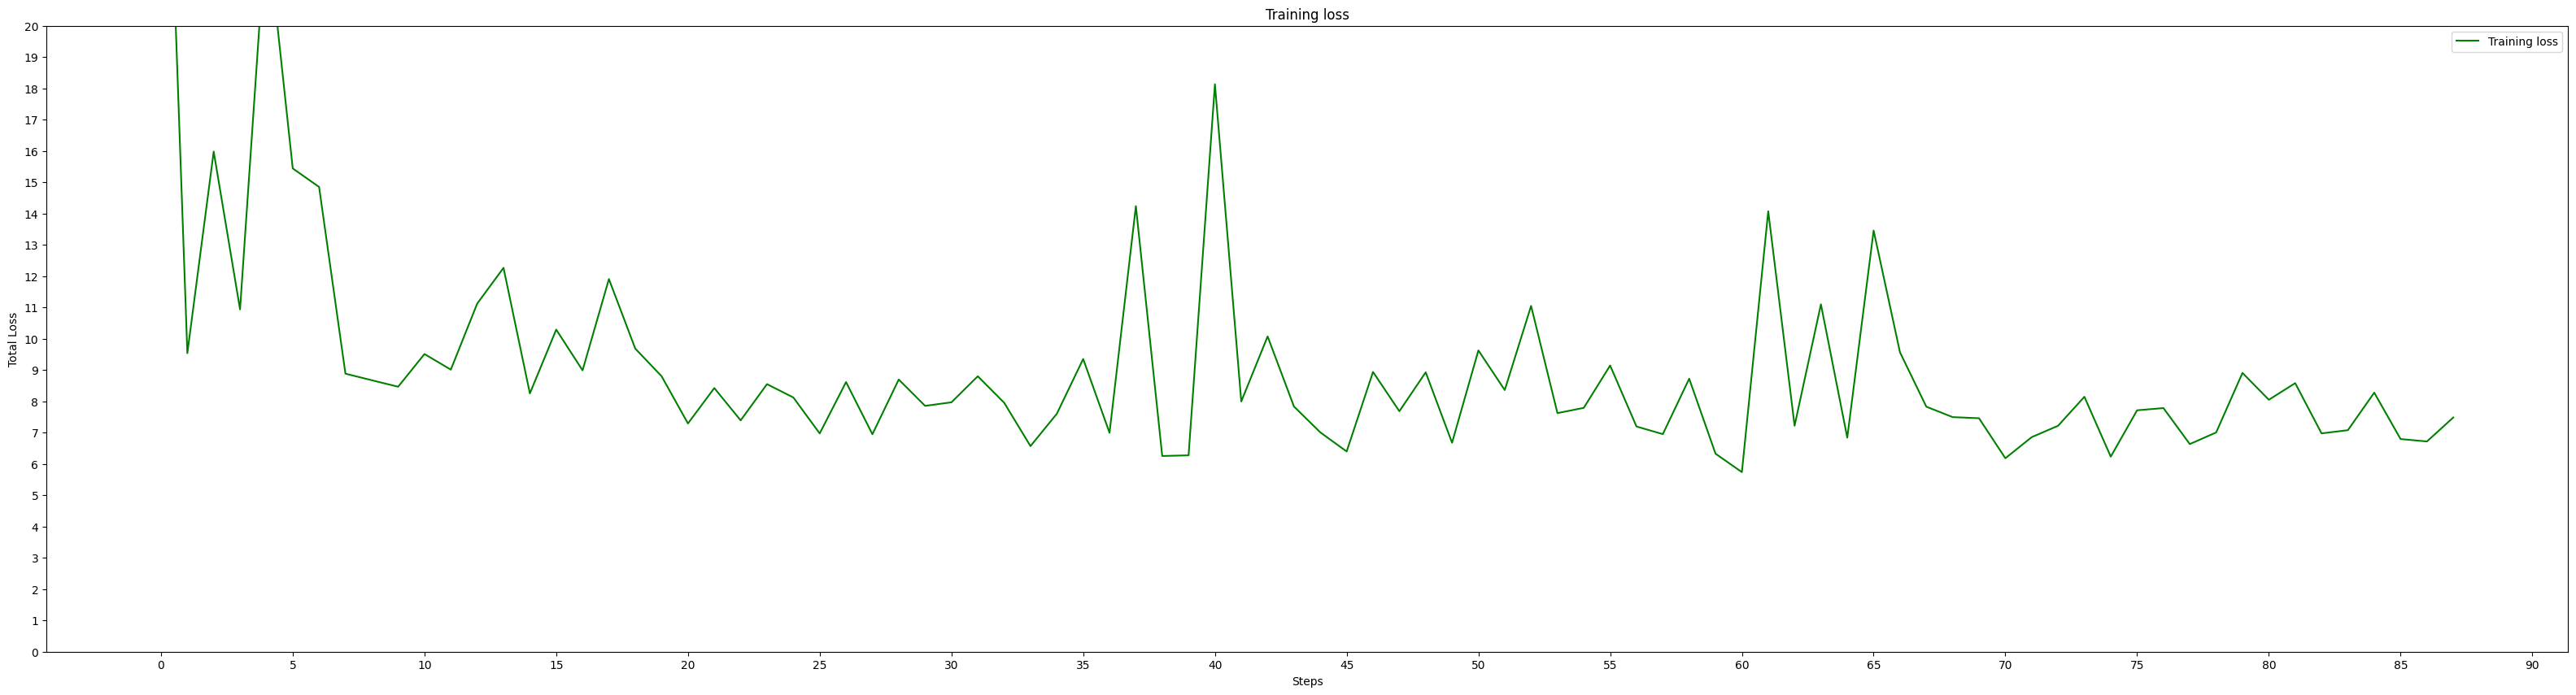

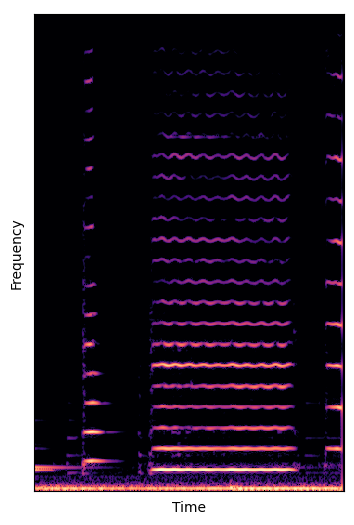

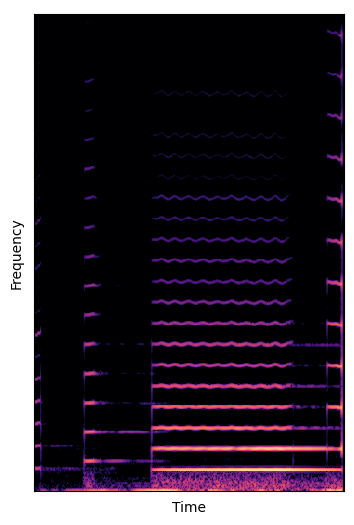

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [26]:
for i in range(input_audios['audio'].shape[0]):
    print("Original audio: ")
    play(input_audios['audio'][i])
    specplot(input_audios['audio'][i])

    print("Reconstructed audio: ")
    play(outputs['synth_audio'][i])
    specplot(outputs['synth_audio'][i])

## TFLite

In [ ]:
def do_convert():
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.DEBUG)

    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    #converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS,tf.lite.OpsSet.SELECT_TF_OPS ]

    #converter.representative_dataset = training_data

    tflite_model = converter.convert()


import cProfile
prof = cProfile.Profile()

from viztracer import VizTracer
tracer = VizTracer()
tracer.tracer_entries = 10000000000

tick_duration_sec = 240.0

def delayed_func(profiler_dump_counter=0):
    #prof.dump_stats(f'profiling_logs_full_delayed_{profiler_dump_counter}')

    tracer.stop()
    tracer.save(f'profiling_logs_full_delayed_{profiler_dump_counter}.html')
    tracer.start()
    #print(f"..dumping...")

    timer = threading.Timer(tick_duration_sec, lambda: delayed_func(profiler_dump_counter+1))
    timer.start()

import threading
import time

# Schedule the function to be executed after 20 seconds
tracer.start()
timer = threading.Timer(tick_duration_sec, lambda: delayed_func(0))
timer.start()

import cProfile
#prof.run("do_convert()")

#time.sleep(120)
do_convert()

instrument_z.shape=(1, 1000, 128)
debug: DAGLayer(<class 'ddsp.processors.ProcessorGroup'>) received input={'f0_hz': <tf.Tensor 'f0_hz:0' shape=(1, 1000, 1) dtype=float32>, 'amplitudes': <tf.Tensor 'midi_expression_ae/synth_coder/fc_harmonic_decoder/dense_2/BiasAdd:0' shape=(1, 1000, 1) dtype=float32>, 'harmonic_distribution': <tf.Tensor 'midi_expression_ae/synth_coder/fc_harmonic_decoder/dense_3/BiasAdd:0' shape=(1, 1000, 60) dtype=float32>, 'noise_magnitudes': <tf.Tensor 'midi_expression_ae/synth_coder/fc_harmonic_decoder/dense_4/BiasAdd:0' shape=(1, 1000, 65) dtype=float32>}
<class 'tensorflow.python.framework.ops.Tensor'>
FcStack: reshaped x to (1000, 10).
FcStack: reshaped x back to (1, 1000, 512).


Successfully cloned a model.
debug: DAGLayer(<class 'ddsp.processors.ProcessorGroup'>) received input={'f0_hz': <tf.Tensor 'f0_hz:0' shape=(None, 1000, 1) dtype=float32>, 'amplitudes': <tf.Tensor 'midi_expression_ae/synth_coder/fc_harmonic_decoder/dense_2/BiasAdd:0' shape=(None, 1000, 1) dtype=float32>, 'harmonic_distribution': <tf.Tensor 'midi_expression_ae/synth_coder/fc_harmonic_decoder/dense_3/BiasAdd:0' shape=(None, 1000, 60) dtype=float32>, 'noise_magnitudes': <tf.Tensor 'midi_expression_ae/synth_coder/fc_harmonic_decoder/dense_4/BiasAdd:0' shape=(None, 1000, 65) dtype=float32>}
batch_size=Tensor("midi_expression_ae/filtered_noise/strided_slice_1:0", shape=(), dtype=int32), audio_shape=Tensor("midi_expression_ae/filtered_noise/Shape_2:0", shape=(2,), dtype=int32), audio=Tensor("midi_expression_ae/filtered_noise/random_uniform:0", shape=(None, None), dtype=float32), batch_size_ir=Tensor("midi_expression_ae/filtered_noise/strided_slice_4:0", shape=(), dtype=int32), ir_shape=Tensor(

OperatorNotAllowedInGraphError: Exception encountered when calling layer "filtered_noise" (type FilteredNoise).

Using a symbolic `tf.Tensor` as a Python `bool` is not allowed: AutoGraph is disabled in this function. Try decorating it directly with @tf.function.

Call arguments received by layer "filtered_noise" (type FilteredNoise):
  • args=('tf.Tensor(shape=(1, 1000, 65), dtype=float32)',)
  • return_outputs_dict=True
  • kwargs={'training': 'False'}
  In call to configurable 'run_dag' (<function DAGLayer.run_dag at 0x000002BA4240F1F0>)

In [35]:
print(tflite_model)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
loss_helper.get_loss_log()

'| loss_amp 0.0000 | loss_f0 0.0000 | loss_hd 0.0000 | loss_noise 0.0000 | loss_spectral_synth 0.0000 | loss_spectral_midi 0.0000 | total_loss 0.0000 '

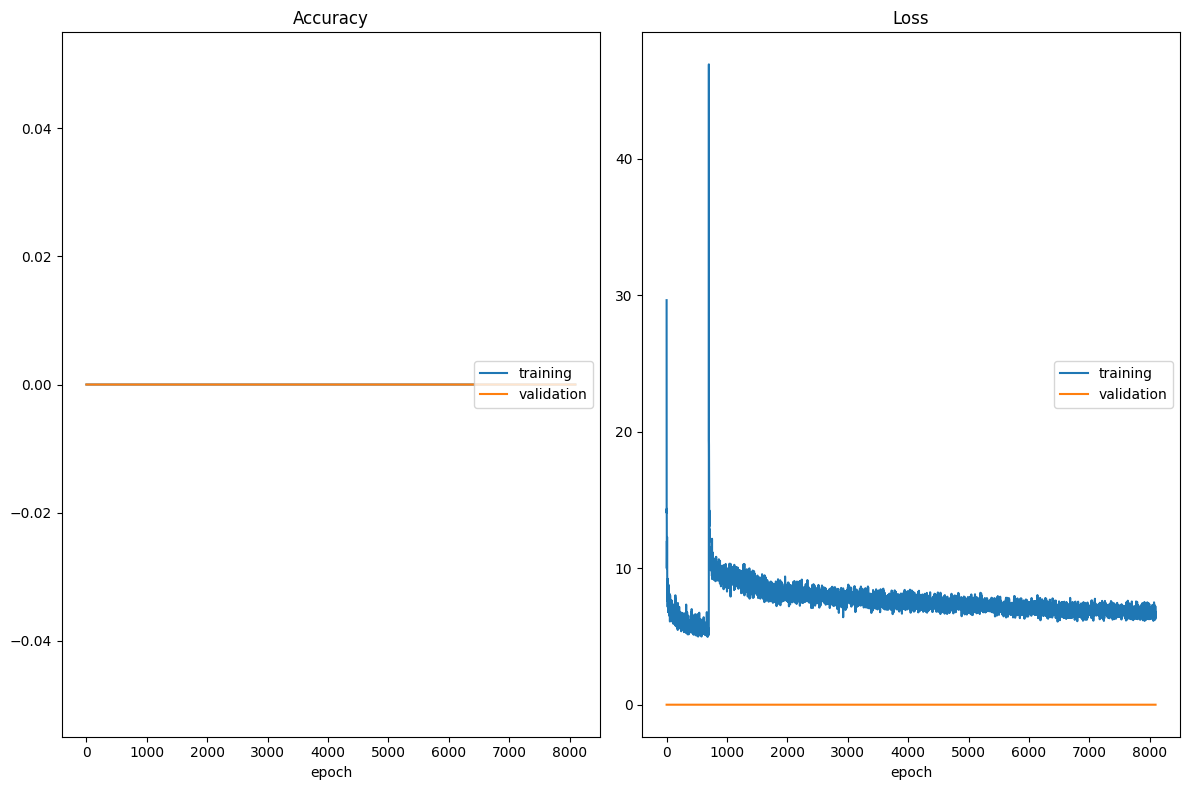

Accuracy
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    4.965, max:   46.907, cur:    6.795)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [25]:
#plotlosses.update({'acc': 0, 'val_acc': 0, 'loss': loss_dict_recon['total_loss'], 'val_loss': 0})
plotlosses.send()

In [29]:
model.save_weights(f'{log_dir}/8000/{8000}')

In [32]:
!pip install matplotlib==3.6.1

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'e:\\code\\projects\\coursework\\ddsp-playground\\ddsp-playground-2\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp38-win_amd64.pyd'
Check the permissions.

You should consider upgrading via the 'E:\Code\Projects\Coursework\ddsp-playground\ddsp-playground-2\Scripts\python.exe -m pip install --upgrade pip' command.


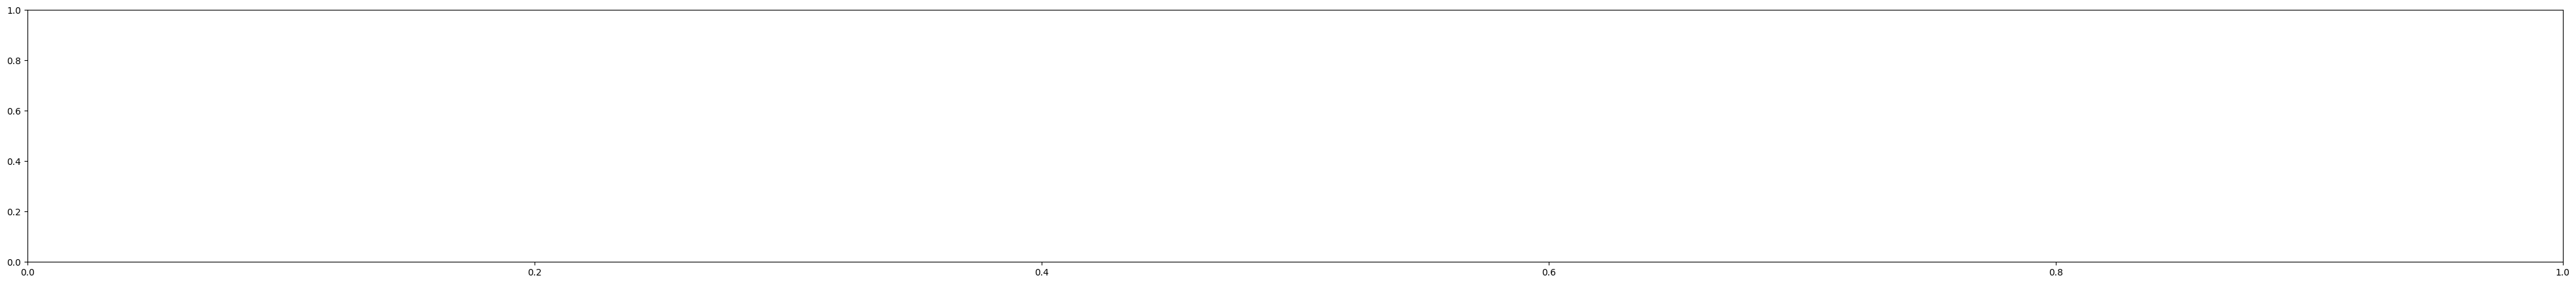

In [28]:
import matplotlib.pyplot as plt
from ddsp.colab.notebook_utils import play, specplot

fig, ax = plt.subplots(figsize=(50,5))

In [50]:

for ii, ex in enumerate(iter(training_data)):
    data_item = ex

    if ii == 10:
        break

play(data_item['audio'][0])

min_db.shape=()
loudness_db.shape=(1000,)
mean_db.shape=()
smoothened_f0_confidence.shape=(1000,)
ld_diff.shape=(1000,)
db.shape=(1000,)
db_threshold.shape=()
note_on_ratio.shape=(1000,)
mask_on.shape=(1000,)
pitch.shape=(1000, 1)
masked_pitch.shape=(947, 1)
int_mask.shape=(1000,)
(1000, 1)
-66.48921
tf.Tensor(-66.489204, shape=(), dtype=float32)
(1000,)
(1000,)


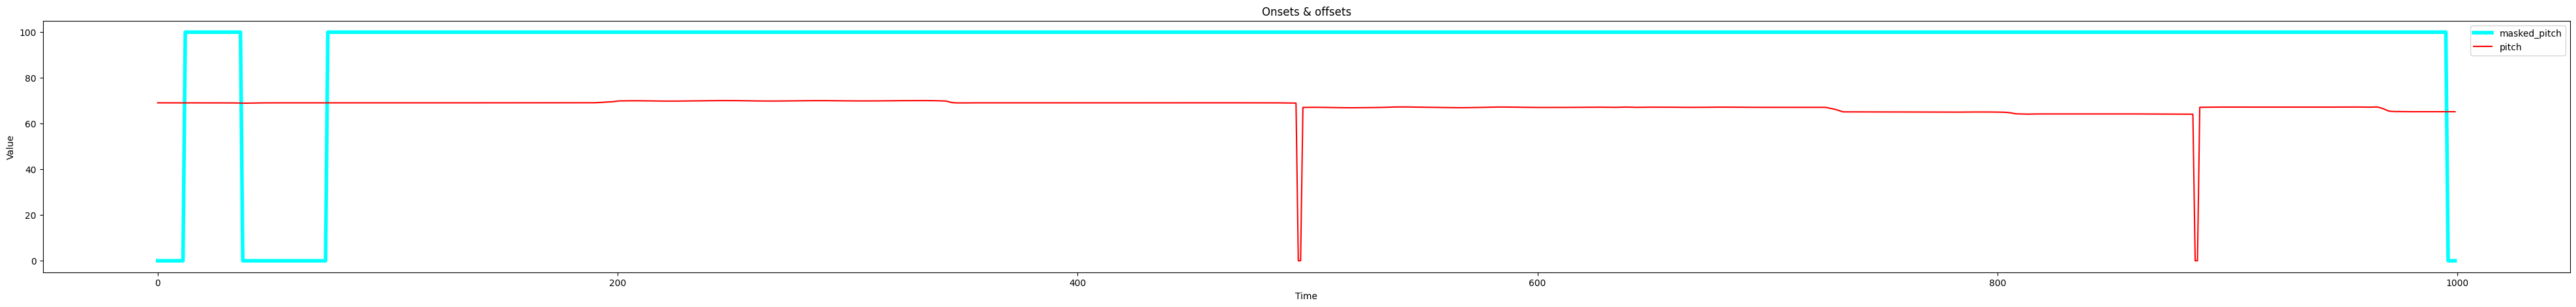

In [54]:
from ddsp import spectral_ops
import ddsp
from ddsp.training.postprocessing import (detect_notes, smooth)
import numpy as np

def detect_notes_v2(loudness_db,
                 f0_confidence,
                 note_threshold=1.0,
                 exponent=2.0,
                 smoothing=40,
                 f0_confidence_threshold=0.7,
                 min_db=-spectral_ops.DB_RANGE):
  """Detect note on-off using loudness and smoothed f0_confidence."""

  # loudness_db should have 1 dim
  loudness_db = tf.squeeze(loudness_db, axis=-1)

  assert(len(loudness_db.shape) == 1)

  min_db = tf.constant(min_db, dtype=tf.float32)
  print(f"min_db.shape={min_db.shape}")
  print(f"loudness_db.shape={loudness_db.shape}")

  mean_db = tf.math.reduce_mean(loudness_db)
  print(f"mean_db.shape={mean_db.shape}")

  smoothened_f0_confidence = smooth(f0_confidence**exponent, smoothing)
  print(f"smoothened_f0_confidence.shape={smoothened_f0_confidence.shape}")

  ld_diff = (loudness_db - min_db)
  print(f"ld_diff.shape={ld_diff.shape}")

  db = smoothened_f0_confidence * ld_diff
  print(f"db.shape={db.shape}")

  db_threshold = (mean_db - min_db) * f0_confidence_threshold**exponent
  print(f"db_threshold.shape={db_threshold.shape}")

  note_on_ratio = db / db_threshold
  print(f"note_on_ratio.shape={note_on_ratio.shape}")

  mask_on = note_on_ratio >= note_threshold
  print(f"mask_on.shape={mask_on.shape}")

  return mask_on, note_on_ratio

ii = 0
onsets = data_item['onsets'][ii]
offsets = data_item['offsets'][ii]
f0s = data_item['f0_hz'][ii]
midis = data_item['midi'][ii]
play(data_item['audio'][ii])

generated_mask_on, generated_note_on_ratio = detect_notes_v2(loudness_db=data_item['loudness_db'][ii], f0_confidence=data_item['f0_confidence'][ii])

pitch = ddsp.core.hz_to_midi(data_item['f0_hz'][ii])
masked_pitch = pitch[generated_mask_on]
int_mask = tf.where(generated_mask_on, 100, 0)

print(f"pitch.shape={pitch.shape}")
print(f"masked_pitch.shape={masked_pitch.shape}")
print(f"int_mask.shape={int_mask.shape}")
#im = ax.imshow(generated_mask_on)
#plt.show()

print(data_item['loudness_db'][ii].shape)
print(np.mean(data_item['loudness_db'][ii]))
print(tf.math.reduce_mean(data_item['loudness_db'][ii]))
print(onsets.shape)
print(generated_mask_on.shape)

#print(f"pitch={pitch}")
#print(f"pitch={masked_pitch}")

#plt.locator_params(nbins=30)

#ax = plt.gca()
ax.clear()
#ax.set_ylim([0, 20])

#ax.set_ylim([0, 125])
#ax.plot(masked_pitch, 'cyan', label='masked_pitch', linewidth=4)
ax.plot(int_mask, 'cyan', label='masked_pitch', linewidth=4)
ax.plot(pitch, 'red', label='pitch')
#ax.plot(onsets * 100, 'g', label='Onsets')
#ax.plot(offsets * 100, 'r', label='Offsets')
#ax.plot(f0s, 'blue', label='f0')
#ax.plot(midis, 'b', label='midi')
ax.set_title('Onsets & offsets')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
fig
#fig.show()

#plt.close('all')
#plt.clf()
#plt.cla()
#plt.close('all')